In [1]:
import matplotlib.pyplot as plt

import numpy as np

import SimpleITK as sitk

## Read the images

In [2]:
def read_image(file_path, print_meta=True, print_stats=False):
    """
    Read NIfTI/NRRD file to sitk image
    """
    sitk_image = sitk.ReadImage(file_path)
    
    if print_meta:
        print("Loaded image:", file_path.split('/')[-1])
        print("Patient ID:", file_path.split('/')[-1].split('_')[0])

        if '_gtvt' in file_path:
            modality = 'Binary GTV mask'
            sitk_image = sitk.Cast(sitk_image, sitk.sitkUInt8)
        elif '_ct' in file_path: modality = 'CT'
        elif '_pt' in file_path: modality = 'PT'
        print("Modality:", modality)

        image_size = sitk_image.GetSize()
        pixel_spacing = sitk_image.GetSpacing()
        print("Image size:", image_size)
        print("Pixel spacing (mm):", pixel_spacing)
        print("Physical size (mm):", [image_size[i]*pixel_spacing[i] for i in range(3)])

    
    if print_stats:
        image_stats = sitk.StatisticsImageFilter()
        image_stats.Execute(sitk_image)

        print(f"\n----- Image Statistics ----- \n Max Intensity: {image_stats.GetMaximum()} \
                \n Min Intensity: {image_stats.GetMinimum()} \n Mean: {image_stats.GetMean()} \
                \n Variance: {image_stats.GetVariance()} \n")

        #print("Components per pixel:", sitk_image.GetNumberOfComponentsPerPixel())

    print("\n")
    return sitk_image

In [3]:
# Read resampled CT
image_path = "sample data/CHGJ015/CHGJ015_ct.nii.gz"
ct_sitk = read_image(image_path)

# Read resampled PET
image_path = "sample data/CHGJ015/CHGJ015_pt.nii.gz"
pet_sitk = read_image(image_path)

# Read resampled original GTV
image_path = "sample data/CHGJ015/CHGJ015_ct_gtvt.nii.gz"
true_gtv_sitk = read_image(image_path)

# Read predicted GTV
image_path = "sample data/CHGJ015/predicted_ct_gtvt.nrrd"
pred_gtv_sitk = read_image(image_path)

Loaded image: CHGJ015_ct.nii.gz
Patient ID: CHGJ015
Modality: CT
Image size: (141, 141, 48)
Pixel spacing (mm): (1.0, 1.0, 3.0)
Physical size (mm): [141.0, 141.0, 144.0]


Loaded image: CHGJ015_pt.nii.gz
Patient ID: CHGJ015
Modality: PT
Image size: (141, 141, 48)
Pixel spacing (mm): (1.0, 1.0, 3.0)
Physical size (mm): [141.0, 141.0, 144.0]


Loaded image: CHGJ015_ct_gtvt.nii.gz
Patient ID: CHGJ015
Modality: Binary GTV mask
Image size: (141, 141, 48)
Pixel spacing (mm): (1.0, 1.0, 3.0)
Physical size (mm): [141.0, 141.0, 144.0]


Loaded image: predicted_ct_gtvt.nrrd
Patient ID: predicted
Modality: Binary GTV mask
Image size: (141, 141, 48)
Pixel spacing (mm): (1.0, 1.0, 3.0)
Physical size (mm): [141.0, 141.0, 144.0]




## Display original CT, PET and GTV, individually and with sitk overlay

In [15]:
def display_image(sitk_image,
                  axial_idxs=[], coronal_idxs=[], sagittal_idxs=[],
                  window_level = None, window_width = None,
                  title=None, dpi=100):
    """
    TODO: Add feature to display slices along only 1 or 2 axes
    """

    spacing = sitk_image.GetSpacing()


    if window_level != None and window_width != None:
        # Apply window and change scan image scale to 0-255
        window_min = window_level - window_width//2
        window_max = window_level + window_width//2
        sitk_image = sitk.Cast(sitk.IntensityWindowing(sitk_image, windowMinimum=window_min, windowMaximum=window_max,
                                                       outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

    ndarray = sitk.GetArrayFromImage(sitk_image)


    # Figure settings
    figsize = (20,10)
    fig, [ax1,ax2,ax3] = plt.subplots(3, figsize=figsize)

    # Extract axial slices --
    axial_slices = []
    for idx in axial_idxs:
        if ndarray.ndim == 3 : image2d = ndarray[idx, :, :]
        if ndarray.ndim == 4 : image2d = ndarray[idx, :, :, :]
        axial_slices.append(image2d)

    axial_slices = np.hstack(axial_slices)

    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image height
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
    extent = (0, len(axial_idxs)*n_cols*spacing[0], n_rows*spacing[1], 0)
    ax1.imshow(axial_slices, extent=extent, interpolation=None, cmap='gray')
    ax1.set_title(f"Axial slices: {axial_idxs}")
    ax1.axis('off')


    # Extract coronal slices --
    coronal_slices = []
    for idx in coronal_idxs:
        if ndarray.ndim == 3 : image2d = ndarray[:, idx, :]
        if ndarray.ndim == 4 : image2d = ndarray[:, idx, :, :]
        image2d = np.rot90(image2d, 2)
        coronal_slices.append(image2d)

    coronal_slices = np.hstack(coronal_slices)

    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
    extent = (0, len(coronal_idxs)*n_cols*spacing[0], n_rows*spacing[2], 0)
    ax2.imshow(coronal_slices, extent=extent, interpolation=None, cmap='gray')
    ax2.set_title(f"Coronal slices: {coronal_idxs}")
    ax2.axis('off')


    # Extract sagittal slices --
    sagittal_slices = []
    for idx in sagittal_idxs:
        if ndarray.ndim == 3 : image2d = ndarray[:, :, idx]
        if ndarray.ndim == 4 : image2d = ndarray[:, :, idx, :]
        image2d = np.rot90(image2d, k=2)
        image2d = np.flip(image2d, axis=1)
        sagittal_slices.append(image2d)

    sagittal_slices = np.hstack(sagittal_slices)

    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image height
    extent = (0, len(sagittal_idxs)*n_cols*spacing[1], n_rows*spacing[2], 0)
    ax3.imshow(sagittal_slices, extent=extent, interpolation=None, cmap='gray')
    ax3.set_title(f"Sagittal slices: {sagittal_idxs}")
    ax3.axis('off')

    if title:
        fig.suptitle(title, fontsize='x-large')
    plt.show()
    
    
#########

def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if  components_per_pixel == 1:
        return mask*image
    else:
        return sitk.Compose([mask*sitk.VectorIndexSelectionCast(image,channel) for channel in range(components_per_pixel)])

#########
    
def alpha_blend(image1, image2, alpha = 0.5, mask1=None,  mask2=None):
    '''
    Alpha blend two images, pixels can be scalars or vectors.
    The alpha blending factor can be either a scalar or an image whose
    pixel type is sitkFloat32 and values are in [0,1].
    The region that is alpha blended is controled by the given masks.
    '''

    if not mask1:
        mask1 = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + 1.0
        mask1.CopyInformation(image1)
    else:
        mask1 = sitk.Cast(mask1, sitk.sitkFloat32)
    if not mask2:
        mask2 = sitk.Image(image2.GetSize(),sitk.sitkFloat32) + 1
        mask2.CopyInformation(image2)
    else:
        mask2 = sitk.Cast(mask2, sitk.sitkFloat32)
    # if we received a scalar, convert it to an image
    if type(alpha) != sitk.SimpleITK.Image:
        alpha = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + alpha
        alpha.CopyInformation(image1)
    components_per_pixel = image1.GetNumberOfComponentsPerPixel()
    if components_per_pixel>1:
        img1 = sitk.Cast(image1, sitk.sitkVectorFloat32)
        img2 = sitk.Cast(image2, sitk.sitkVectorFloat32)
    else:
        img1 = sitk.Cast(image1, sitk.sitkFloat32)
        img2 = sitk.Cast(image2, sitk.sitkFloat32)

    intersection_mask = mask1*mask2

    intersection_image = mask_image_multiply(alpha*intersection_mask, img1) + \
                         mask_image_multiply((1-alpha)*intersection_mask, img2)
    return intersection_image + mask_image_multiply(mask2-intersection_mask, img2) + \
           mask_image_multiply(mask1-intersection_mask, img1)

#########

def display_overlay_image(ct_sitk, pet_sitk=None, true_gtv_sitk=None, pred_gtv_sitk=None,
                           axial_idxs=[], coronal_idxs=[], sagittal_idxs=[],
                           ct_window_level=None, ct_window_width=None,
                           pet_window_level=None, pet_window_width=None,
                           gtv_as_contour=False,
                           pet_ct_alpha=0.3, gtv_opacity=0.5, 
                           title=None, dpi=80):

    # Apply window and change scan image scale to 0-255
    if ct_window_level != None and ct_window_width != None:

        ct_window_min = ct_window_level - ct_window_width//2
        ct_window_max = ct_window_level + ct_window_width//2
        ct_sitk = sitk.Cast(sitk.IntensityWindowing(ct_sitk, 
                                                    windowMinimum=ct_window_min, windowMaximum=ct_window_max,
                                                    outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

   # Apply window and change scan image scale to 0-255
    if pet_sitk != None:

        if pet_window_level != None and pet_window_width != None:

            pet_window_min = pet_window_level - pet_window_width//2
            pet_window_max = pet_window_level + pet_window_width//2
            pet_sitk = sitk.Cast(sitk.IntensityWindowing(pet_sitk, 
                                                         windowMinimum=pet_window_min, windowMaximum=pet_window_max,
                                                         outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

        scan_sitk = alpha_blend(ct_sitk, pet_sitk, alpha=pet_ct_alpha)
        scan_sitk = sitk.Cast(scan_sitk, sitk.sitkUInt8)
    else:
        scan_sitk = ct_sitk
    
    
    # Overlay gtv mask over the scan --
    
    if gtv_as_contour:
        true_gtv_contour = sitk.LabelContour(true_gtv_sitk, fullyConnected=True) # Convert segmentation to contour
        overlay_image = sitk.LabelOverlay(scan_sitk, true_gtv_contour, 
                                          opacity=1)
        
        # Display the predicted GTV (along with true GTV) only if contour mode is enabled
        if pred_gtv_sitk:
            # Combine the 2 gtv masks into one
            true_gtv_np = sitk.GetArrayFromImage(true_gtv_sitk)
            pred_gtv_np = sitk.GetArrayFromImage(pred_gtv_sitk)
            combined_gtv_mask = pred_gtv_np * 2      # Change predicted GTV's label to 2
            combined_gtv_mask[true_gtv_np == 1] = 1  # Keep true GTV's label as 1
            combined_gtv_mask = sitk.GetImageFromArray(combined_gtv_mask)
            combined_gtv_mask.CopyInformation(true_gtv_sitk)
            combined_gtv_contour = sitk.LabelContour(combined_gtv_mask, fullyConnected=True) # Convert segmentation to contour
            overlay_image = sitk.LabelOverlay(scan_sitk, combined_gtv_contour, 
                                              opacity=gtv_opacity)
            
    else:
        overlay_image = sitk.LabelOverlay(scan_sitk, true_gtv_sitk, 
                                          opacity=gtv_opacity)

        
        
    # Display
    display_image(overlay_image,
                   axial_idxs=axial_idxs, 
                   coronal_idxs=coronal_idxs,
                   sagittal_idxs=sagittal_idxs,
                   window_level=None, window_width=None,
                   dpi=dpi, title=title)


### CT only

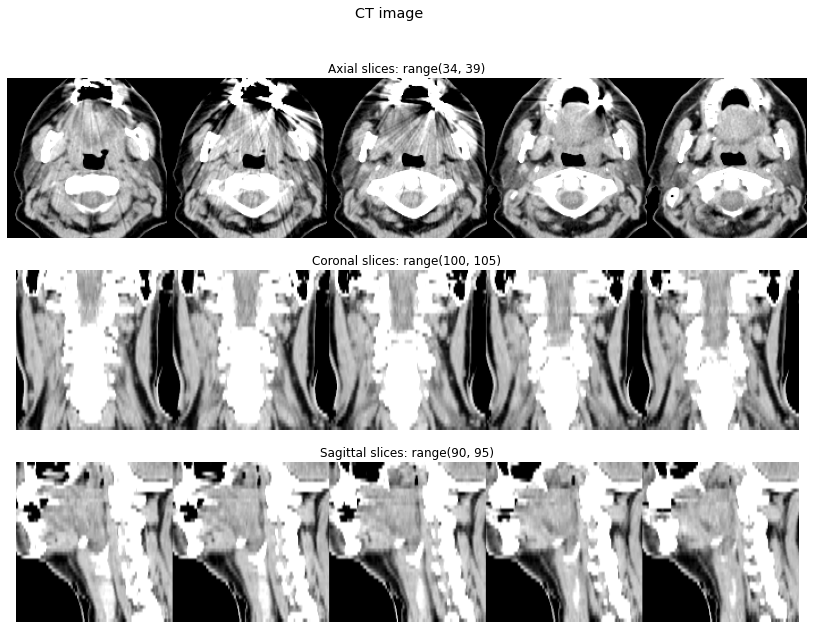

In [5]:
display_image(ct_sitk,
               axial_idxs=range(34,39),
               coronal_idxs=range(100,105),
               sagittal_idxs=range(90,95),
               window_level = 0, window_width = 200,
               title="CT image")

### CT + PET + GTV segmentation overlay

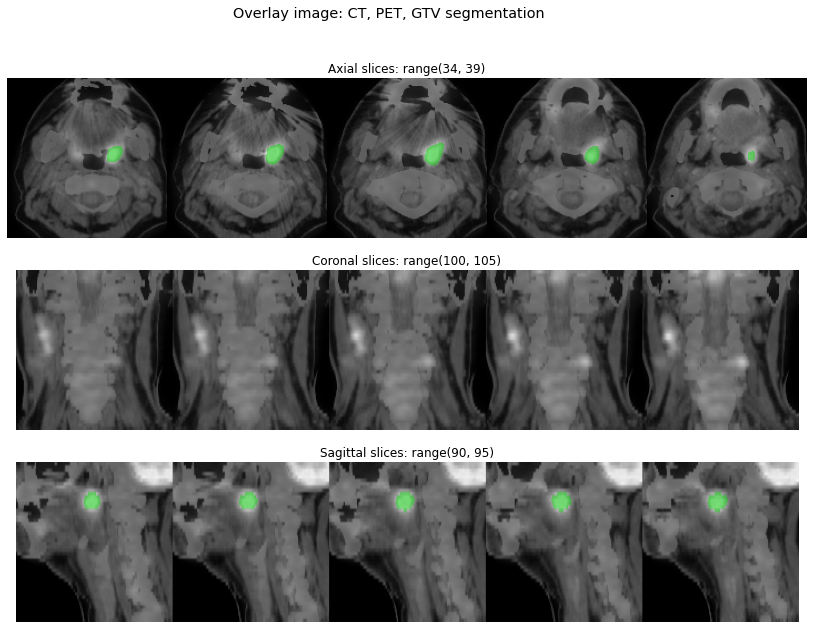

In [6]:

display_overlay_image(ct_sitk, pet_sitk, true_gtv_sitk, 
                       axial_idxs=range(34,39),
                       coronal_idxs=range(100,105),
                       sagittal_idxs=range(90,95),
                       gtv_opacity=0.5, pet_ct_alpha=0.3,
                       ct_window_level = 0, ct_window_width = 200,
                       pet_window_level = 5, pet_window_width = 10,
                       title="Overlay image: CT, PET, GTV segmentation")


###  CT + PET + original GTV contour + predicted GTV contour overlay

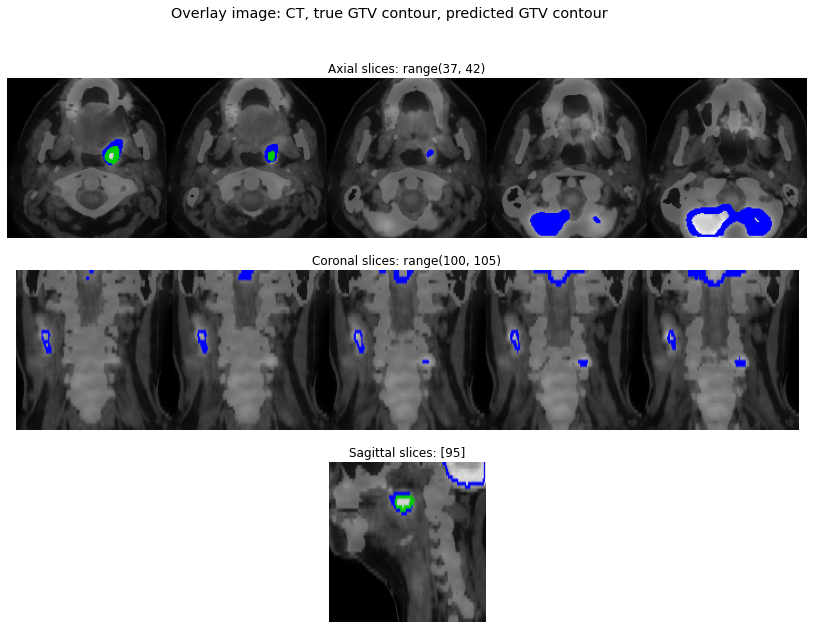

In [30]:
# Green-True GTV; Blue-Predicted GTV 

display_overlay_image(ct_sitk, pet_sitk,
                       true_gtv_sitk=true_gtv_sitk, pred_gtv_sitk=pred_gtv_sitk, 
                       axial_idxs=range(37,42),
                       coronal_idxs=range(100,105),
                       sagittal_idxs=[95],
                       ct_window_level = 50, ct_window_width = 200,
                       pet_window_level = 5, pet_window_width = 10,
                       gtv_as_contour=True, gtv_opacity=1,
                       title="Overlay image: CT, true GTV contour, predicted GTV contour")


## Display single CT, PET and GTV slices side-by-side

In [8]:
def display_slice(ct_slice_sitk, pet_slice_sitk, 
                       true_gtv_slice_sitk=None, pred_gtv_slice_sitk=None, 
                       title=None, dpi=100):
    """
    Display corresponding slices of CT, PET and GTV side-by-side.
    Note: CT and PET need to have same size and spacing -- i.e. only resampled images should be used
    
    """
    
    n_inputs = 2
    
    ct_slice_sitk = sitk.Cast(sitk.IntensityWindowing(ct_slice_sitk, windowMinimum=-200, windowMaximum=600,
                                                       outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
    pet_slice_sitk = sitk.Cast(sitk.IntensityWindowing(pet_slice_sitk, windowMinimum=0, windowMaximum=10,
                                                       outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
    
    
    ct_slice_np = sitk.GetArrayFromImage(ct_slice_sitk)
    pet_slice_np = sitk.GetArrayFromImage(pet_slice_sitk)
    if true_gtv_slice_sitk:
        true_gtv_slice_sitk = true_gtv_slice_sitk * 255
        true_gtv_slice_np = sitk.GetArrayFromImage(true_gtv_slice_sitk)
        n_inputs += 1
    if pred_gtv_slice_sitk:
        pred_gtv_slice_sitk = pred_gtv_slice_sitk * 255
        pred_gtv_slice_np = sitk.GetArrayFromImage(pred_gtv_slice_sitk)
        n_inputs += 1

        
    spacing = ct_slice_sitk.GetSpacing() # Get pixel spacing of the slice
    extent = (0, ct_slice_np.shape[0]*spacing[1], ct_slice_np.shape[1]*spacing[0], 0)
    figsize = (n_inputs*5,5)
    #figsize = (n_inputs*ct_slice_np.shape[1]/dpi, n_images*ct_slice_np.shape[0]/dpi)
    
    fig, axs = plt.subplots(nrows=1, ncols=n_inputs, figsize=figsize)
    
    axs[0].imshow(ct_slice_np, extent=extent, interpolation=None, cmap='gray')
    axs[0].set_title("CT")
    axs[1].imshow(pet_slice_np, extent=extent, interpolation=None, cmap='gray')
    axs[1].set_title("PET")    
    
    if true_gtv_slice_sitk: 
        axs[2].imshow(true_gtv_slice_np, extent=extent, interpolation=None, cmap='gray')
        axs[2].set_title("Actual GTV")
    if pred_gtv_slice_sitk:
        axs[3].imshow(pred_gtv_slice_np, extent=extent, interpolation=None, cmap='gray')
        axs[3].set_title("Predicted GTV")
        
    for ax in axs: ax.axis('off')
    if title: fig.suptitle(title, fontsize='x-large')
    plt.show()


### CT, PET, original GTV segmentation and predicted GTV segmentation side-by-side

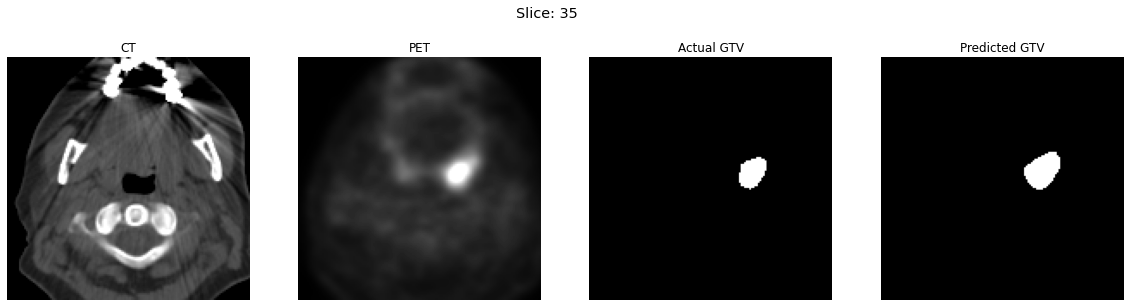

In [9]:
slice_number = 35
display_slice(ct_sitk[:,:,slice_number], pet_sitk[:,:,slice_number], 
              true_gtv_sitk[:,:,slice_number], pred_gtv_sitk[:,:,slice_number],
              title="Slice: "+str(slice_number))

## Display CT, PET and GTV as different color channels -- TODO 